# Fit the optical spectrum of Type 1 AGN (SDSS J094310.12+604559.1)
* Check [astropy.modelling](https://docs.astropy.org/en/latest/modeling/index.html) for more introduction
* SAGAN adopts the frame work of astropy.modelling
* Modified by Guodong and edited on 2025-01-12

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.time import Time

from astropy.modeling import models, fitting
import sys
sys.path.append('../../SAGAN-Modified/')
import sagan


import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

# Find the Spectrum from the SDSS archive
* Check [astroquery.sdss](https://astroquery.readthedocs.io/en/latest/sdss/sdss.html) for more introduction

/Users/liguodong/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Text(0.5, 1.0, 'SDSS J082912.67+500652.3')

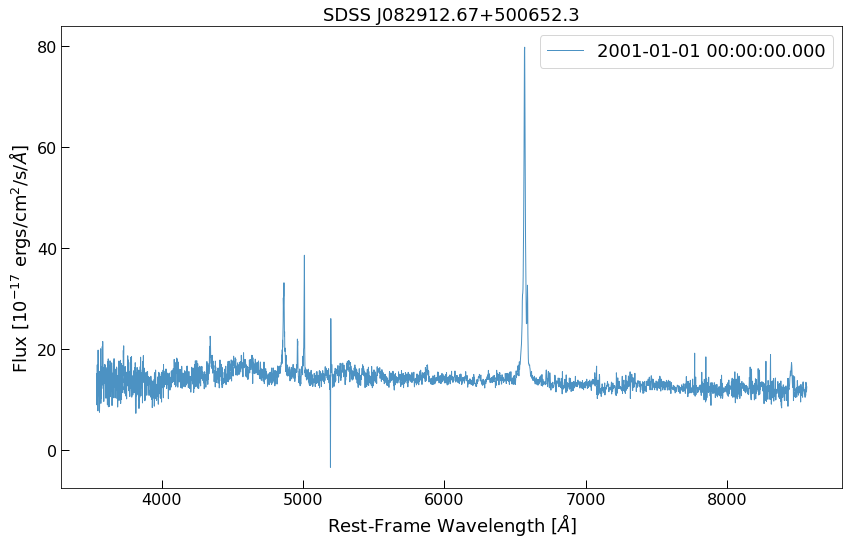

In [2]:
#Find the spectrum
name='J094310.12+604559.1'
pos = coords.SkyCoord('09h43m10.12s +60d45m59.1s', frame='icrs')
xid = SDSS.query_region(pos, spectro=True,radius=5*u.arcsec)
sp = SDSS.get_spectra(matches=xid)

fig, ax = plt.subplots(figsize=(14.,8.5))
for i in np.arange(xid['ra'].size):
    hdr=sp[i][0].header
    t   =Time(float(hdr['MJD']),format='mjd')
    t.format='iso'
    ax.plot((10.**sp[i][1].data['loglam'])/(1+sp[i][2].data['z'][0]),sp[i][1].data['flux'],label=t.value,linewidth=1,alpha=0.8)
ax.set_ylabel(r'Flux [10$^{-17}$ ergs/cm$^2$/s/$\AA$]',fontsize=18)
ax.set_xlabel('Rest-Frame Wavelength [$\AA$]',fontsize=18)
ax.legend(loc='upper right',fontsize=18)
ax.set_title('SDSS J082912.67+500652.3',fontsize=18)

### Read data and correct the Milky Way extinction
* Check [here](https://github.com/kbarbary/sfddata) for dust map
* Check [here](https://github.com/sczesla/PyAstronomy/tree/master) for the dust correction

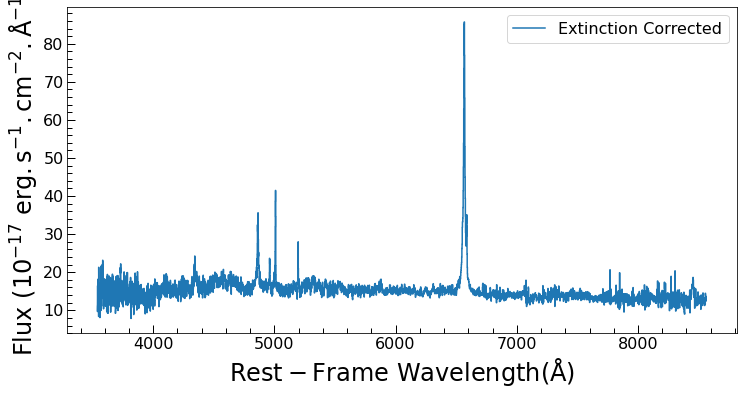

In [3]:
#Select the first spectrum and make the dust correction from the Milky Way (Schlegel, Finkbeiner and Davis 1998)
hdu = sp[0]
lam_res_unred, flux_res_unred, err_unred = sagan.ReadSpectrum(is_sdss=True, hdu=hdu).unredden_res()

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(lam_res_unred, flux_res_unred, label='Extinction Corrected', c='C0')
#ax.set_yscale('log')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.legend(fontsize=16)
ax.minorticks_on()
plt.show()

### Cut the useful data
* First move to the rest frame
* Cut the wavelength range following Kuhn et al. (2024)

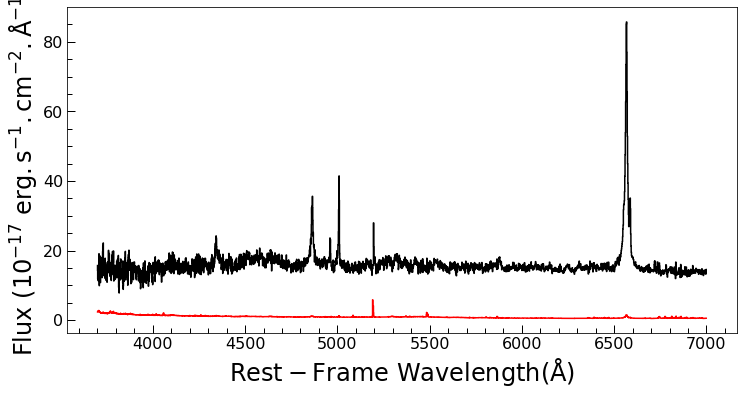

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 3700, 7000
fltr = (lam_res_unred > wmin) & (lam_res_unred < wmax)
wave_use = lam_res_unred[fltr]
flux_use = flux_res_unred[fltr]
ferr = err_unred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.step(wave_use, ferr, color='r')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
#ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.minorticks_on()
plt.show()

### Fit spectrum
* Check the emission lines here: http://astronomy.nmsu.edu/drewski/tableofemissionlines.html
* Tie all the narrow lines to [S II] $\lambda\lambda$ 6718,6733 doublet
* Iterate many times until you find a good result
* * The continuum will be fitted using the FeII + PL + Star (A, F, G, K, M) model to a specified spectral window.
* * Fitting [S II] line and using it as narrow line template, fixing the shape of the continuum and optionally fitting its amplitude
* * Fitting other lines, using narrow line template ([S II]) and fixing the shape of the continuum and optionally fitting its amplitude

### Using MCMC
* We define some functions to use MCMC, and generally users do not need to modify them.

In [5]:
import emcee
import corner
from emcee.moves import DEMove, StretchMove

def get_free_params(model):
    free_param_names = []
    for param_name in model.param_names:
        param = getattr(model, param_name)
        if not param.fixed and param.tied is False:
            free_param_names.append(param_name)
    return free_param_names

def log_likelihood(theta, wave_use, flux_use, ferr, model, param_names):
    for i, param_name in enumerate(param_names):
        setattr(model, param_name, theta[i])
    for param_name in model.param_names:
        param = getattr(model, param_name)
        if param.tied: 
            param.value = param.tied(model)   
    model_flux = model(wave_use)
    return -0.5 * np.sum(((flux_use - model_flux) / ferr) ** 2)

def log_probability(theta, wave_use, flux_use, ferr, model, param_names, log_prior_func):
    
    lp = log_prior_func(theta, model, param_names)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(theta, wave_use, flux_use, ferr, model, param_names)
    if not np.isfinite(ll):
        return -np.inf

    return lp + ll

def log_prior(theta, model, param_names):
    for i, param_name in enumerate(param_names):
        bound = getattr(model, param_name).bounds
        lower_bound, upper_bound = bound
        if not (lower_bound <= theta[i] <= upper_bound):
            return -np.inf 
    return 0.0

def Fit_mcmc(wave_use, flux_use, ferr, model, log_prior_func=None, nwalkers=50, nsteps=10000):
    if log_prior_func==None:
        log_prior_func=log_prior
        
    param_names = get_free_params(model)
    for param_name in param_names:
        param = getattr(model, param_name)
        lower_bound, upper_bound = param.bounds
        if upper_bound is None:
            upper_bound = np.inf
        if lower_bound is None:
            lower_bound = -np.inf
        param.bounds = (lower_bound, upper_bound)
        
    param_values = {}      
    for i in param_names:
        param_values[i] = getattr(model, i).value
    theta_initial = [param_values[key] for key in param_names]
    
    ndim = len(theta_initial)
    pos = theta_initial + 1e-6 * np.random.randn(nwalkers, ndim)
    
    move = DEMove()
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, moves=move, args=(wave_use, flux_use, ferr, model, param_names, log_prior_func)
    )

    sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    best_fit_params = np.median(flat_samples, axis=0)
    for i, param_name in enumerate(param_names):
        setattr(model, param_name, best_fit_params[i])

    return flat_samples, model


100%|███████████████████████████████████████| 5000/5000 [01:59<00:00, 41.68it/s]


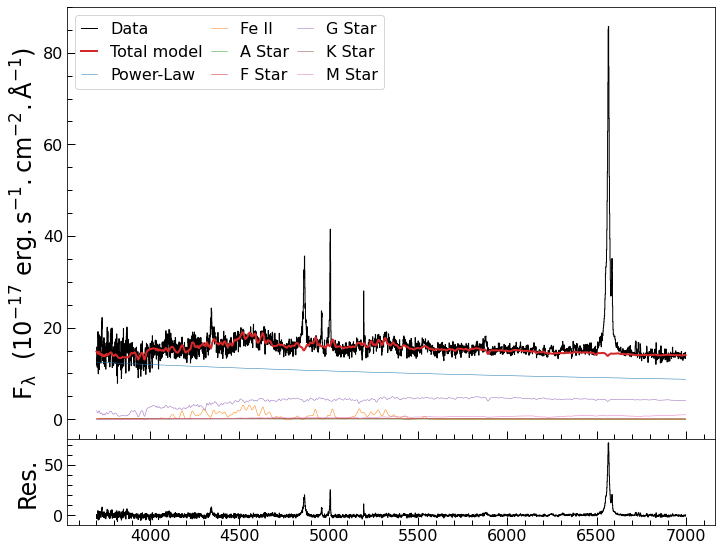

amplitude_0 = 9.9961, error: 0.3489
alpha_0 = 0.5600, error: 0.0746
amplitude_1 = 3.4584, error: 0.4206
stddev_1 = 379.0519, error: 74.9984
amplitude_2 = 0.1404, error: 0.1288
sigma_2 = 307.8559, error: 96.9783
amplitude_3 = 0.2176, error: 0.2871
amplitude_4 = 5.2201, error: 0.3873
amplitude_5 = 0.0909, error: 0.1047
amplitude_6 = 1.1055, error: 0.3051


In [6]:
# fit continuum
def cont_init(wave_use, flux_use, ferr):   
    cont_window_lo = [3700, 3740, 4041, 4150, 5300, 5550, 6000, 6400, 6800]
    cont_window_up = [3715, 3800, 4043, 4250, 5500, 5850, 6290, 6450, 7000]
    ins = np.zeros_like(wave_use, dtype=bool)
    for i in range(len(cont_window_up)):
        ins |= (wave_use > cont_window_lo[i]) & (wave_use < cont_window_up[i])
    cont_x = wave_use[ins]
    cont_y = flux_use[ins]
    cont_y_e = ferr[ins]
    weights = 1/ferr**2
    sdss_velscale = 69.03

    pl = models.PowerLaw1D(amplitude=11, x_0=5500, alpha=0.5, fixed={'x_0': True}, name='Power-Law', bounds={'alpha':(-5, 5)})
    
    iron = sagan.IronTemplate(amplitude=4, stddev=500, z=0, name='Fe II', bounds = {'stddev':(300, 3000)})
    iron.z.fixed = True
    
    Star_A = sagan.StarSpectrum(amplitude=0.2, sigma=450, velscale=sdss_velscale, Star_type='A', name='A Star', 
                                bounds = {'sigma':(50, 1000), 'amplitude':(0,0.5)})
    Star_F = sagan.StarSpectrum(amplitude=0.2, sigma=450, velscale=sdss_velscale, Star_type='F', name='F Star')
    Star_G = sagan.StarSpectrum(amplitude=6.3, sigma=450, velscale=sdss_velscale, Star_type='G', name='G Star')
    Star_K = sagan.StarSpectrum(amplitude=0.1, sigma=450, velscale=sdss_velscale, Star_type='K', name='K Star')
    Star_M = sagan.StarSpectrum(amplitude=1.2, sigma=450, velscale=sdss_velscale, Star_type='M', name='M Star')
    
    def tie_sigma(model):
        return model['A Star'].sigma

    for tem in [Star_F, Star_G, Star_K, Star_M]:
        tem.sigma.tied = tie_sigma
    
    m_init = pl + iron + Star_A + Star_F + Star_G + Star_K + Star_M
    
    samples, m_fit_cont = Fit_mcmc(cont_x, cont_y, cont_y_e, m_init, nwalkers=50, nsteps=5000)
    #fig = corner.corner(samples, labels=param_names, quantiles=[0.16,0.5,0.84],\
    #                    smooth=False, show_titles=True, title_kwargs={"fontsize":12}, title_fmt='.3f')
    #plt.show()

    ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_cont, weight=weights)
    ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
    plt.show()
    
    param_names = get_free_params(m_fit_cont)
    best_fit_params     = np.median(samples, axis=0)
    best_fit_params_err = np.std(samples, axis=0)
    for i, param_name in enumerate(param_names):
        print(f"{param_name} = {best_fit_params[i]:.4f}, error: {best_fit_params_err[i]:.4f}")
        
    return m_fit_cont
    
    
valid = (np.isfinite(wave_use)) & (np.isfinite(flux_use)) & (np.isfinite(ferr))
wave_use = wave_use[valid]
flux_use = flux_use[valid]
ferr = ferr[valid]  
m_fit_cont = cont_init(wave_use, flux_use, ferr)

100%|██████████████████████████████████████| 5000/5000 [00:21<00:00, 231.24it/s]


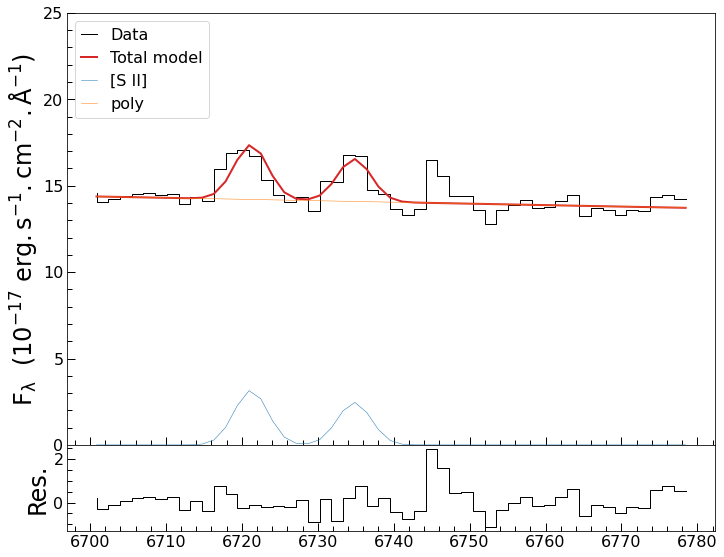

amp_c0_0 = 3.1592, error: 0.4135
amp_c1_0 = 2.4609, error: 0.4178
dv_c_0 = 156.4812, error: 13.6351
sigma_c_0 = 99.1073, error: 12.4386
c0_1 = 71.0409, error: 20.8643
c1_1 = -0.0085, error: 0.0031


In [7]:
def SII_init(wave_use, flux_use, ferr):
    
    wave_dict = sagan.utils.line_wave_dict
    label_dict = sagan.utils.line_label_dict
    
    bounds = {'amp_c0':(0, 100), 'amp_c1':(0, 100), 
              'dv_c':(-1000,1000),'sigma_c':(30, 400)}
    line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, 
                                            wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'],
                                            amp_c0=4, amp_c1=5, dv_c=100, sigma_c=60,
                                            bounds=bounds, 
                                            fixed={'wavec0': True, 'wavec1':True},
                                            name='[S II]')
    poly = models.Polynomial1D(degree=1, name='poly', bounds={'c0': (-10, 100), 'c1': (-10, 10)})
    m_init  = line_s2+poly
    
    samples, m_fit_SII = Fit_mcmc(wave_use, flux_use, ferr, m_init, nwalkers=50, nsteps=5000)
    #fig = corner.corner(samples, labels=param_names, quantiles=[0.16,0.5,0.84],\
    #                    smooth=False, show_titles=True, title_kwargs={"fontsize":12}, title_fmt='.3f')
    #plt.show()
    weights = 1/ferr**2
    ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_SII, weight=weights)
    ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
    ax.set_ylim(0,25)
    plt.show()
    
    param_names = get_free_params(m_fit_SII)
    best_fit_params     = np.median(samples, axis=0)
    best_fit_params_err = np.std(samples, axis=0)
    for i, param_name in enumerate(param_names):
        print(f"{param_name} = {best_fit_params[i]:.4f}, error: {best_fit_params_err[i]:.4f}")
    
    return m_fit_SII, samples

ins = (wave_use>6700)&(wave_use<6780)    
m_fit_SII, samples_SII = SII_init(wave_use[ins], flux_use[ins], ferr[ins]) 

100%|██████████████████████████████████████| 5000/5000 [00:22<00:00, 226.08it/s]


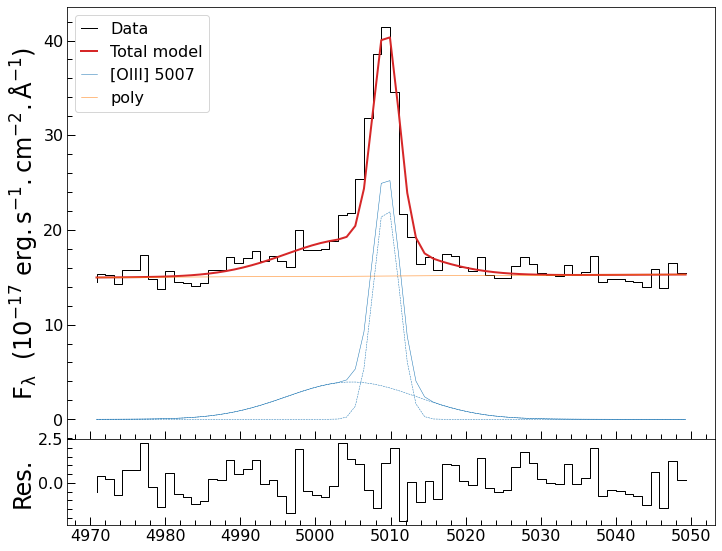

amp_c_0 = 22.8864, error: 1.2368
dv_c_0 = 153.4213, error: 7.9483
sigma_c_0 = 103.5355, error: 5.6470
amp_w0_0 = 0.1721, error: 0.0366
dv_w0_0 = -275.7927, error: 82.7889
sigma_w0_0 = 517.8781, error: 86.1281
c0_1 = -5.0457, error: 27.8610
c1_1 = 0.0040, error: 0.0055


In [8]:
def OIII_init(wave_use, flux_use, ferr):
    wave_dict = sagan.utils.line_wave_dict
    label_dict = sagan.utils.line_label_dict
    line_o3 = sagan.Line_MultiGauss(n_components=2, 
                                    amp_c=10, dv_c=280, sigma_c=100, 
                                    amp_w0=0.5, dv_w0=0, sigma_w0=500,
                                    wavec=wave_dict['OIII_5007'],
                                    name=f'[OIII] 5007', fixed={'wavec': True}
                                    )
    poly = models.Polynomial1D(degree=1, name='poly', bounds={'c0': (-100, 100), 'c1': (-100, 100)})
    m_init  = line_o3+poly
    
    samples, m_fit_OIII_5007 = Fit_mcmc(wave_use, flux_use, ferr, m_init, nwalkers=40, nsteps=5000)
    #fig = corner.corner(samples, labels=param_names, quantiles=[0.16,0.5,0.84],\
    #                    smooth=False, show_titles=True, title_kwargs={"fontsize":12}, title_fmt='.3f')
    #plt.show()
    weights = 1/ferr**2
    ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_OIII_5007, weight=weights)
    ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
    plt.show()
    
    param_names = get_free_params(m_fit_OIII_5007)
    best_fit_params     = np.median(samples, axis=0)
    best_fit_params_err = np.std(samples, axis=0)
    for i, param_name in enumerate(param_names):
        print(f"{param_name} = {best_fit_params[i]:.4f}, error: {best_fit_params_err[i]:.4f}")
    
    return m_fit_OIII_5007, samples

ins = (wave_use>4970)&(wave_use<5050)
m_fit_OIII_5007, samples_OIII_5007 = OIII_init(wave_use[ins], flux_use[ins], ferr[ins])

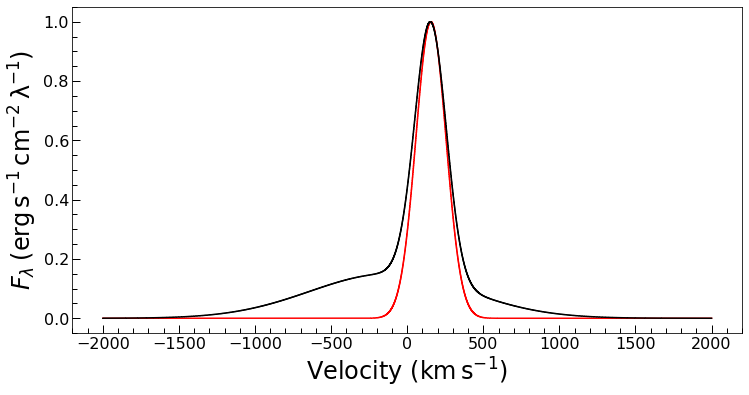

In [9]:
velc_SII_tmpl = np.linspace(-2000, 2000, 4000)
flux_SII_tmpl = m_fit_SII['[S II]'].gen_template(velc_SII_tmpl, normalized=True)

velc_OIII_tmpl = np.linspace(-2000, 2000, 4000)
flux_OIII_tmpl = m_fit_OIII_5007['[OIII] 5007'].gen_template(velc_OIII_tmpl, normalized=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(velc_SII_tmpl, flux_SII_tmpl, color='r')
ax.step(velc_OIII_tmpl, flux_OIII_tmpl, color='k')
ax.set_xlabel(r'Velocity ($\mathrm{km\,s^{-1}}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

100%|███████████████████████████████████████| 3000/3000 [00:36<00:00, 82.17it/s]


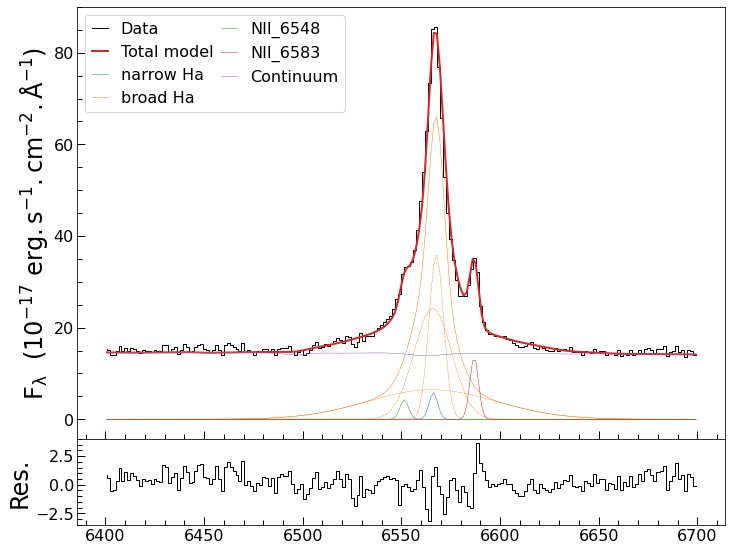

amplitude_0 = 5.8354, error: 7.4627
amp_c_1 = 6.4398, error: 2.4905
dv_c_1 = 120.2266, error: 51.9327
sigma_c_1 = 1485.3043, error: 233.5398
amp_w0_1 = 3.7626, error: 0.9445
dv_w0_1 = 22.2219, error: 52.6064
sigma_w0_1 = 434.4303, error: 66.2660
amp_w1_1 = 5.5760, error: 2.2434
dv_w1_1 = 102.5561, error: 51.5117
sigma_w1_1 = 171.2137, error: 29.3732
amplitude_3 = 13.6384, error: 1.4339


In [10]:
def Fit_Ha(wave_use, flux_use, ferr, velc_tmpl, flux_tmpl, m_fit_cont):
    wave_dict = sagan.utils.line_wave_dict
    label_dict = sagan.utils.line_label_dict
    n_ha = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                               dv=0, amplitude=50,wavec=wave_dict['Halpha'], name=f'narrow Ha', 
                               fixed={'wavec': True, 'dv': True})
    n_NII_1 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                                  dv=0, amplitude=3,wavec=wave_dict['NII_6548'], name=f'NII_6548', 
                                  fixed={'wavec': True, 'dv': True})
    n_NII_2 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                                  dv=0, amplitude=3,wavec=wave_dict['NII_6583'], name=f'NII_6583', 
                                  fixed={'wavec': True, 'dv': True})
    b_ha = sagan.Line_MultiGauss(n_components=3, amp_c=10, dv_c=280, sigma_c=1000, 
                                 wavec=wave_dict['Halpha'],
                                 amp_w0=0.5, dv_w0=0, sigma_w0=500,
                                 amp_w1=0.5, dv_w1=0, sigma_w1=50,
                                 name=f'broad Ha', fixed={'wavec': True}, bounds={'sigma_c':(30, 2000), 'sigma_w0':(50, 2000),'sigma_w1':(30, 500),}
                                 )
    def tie_n2(model):
        return model['NII_6583'].amplitude / 2.96
    n_NII_1.amplitude.tied = tie_n2
    
    line_ha = n_ha+b_ha
    line_NII = n_NII_1+n_NII_2
    
    def m_fit_cont_func(x):
        return m_fit_cont(x)
    cont = sagan.TierContinuum(y_func=m_fit_cont_func, amplitude=1.0, name=f'Continuum', x_static=wave_use)
    cont.amplitude.fixed = True
    
    m_init = line_ha+line_NII+cont
    
    samples, m_fit_Ha = Fit_mcmc(wave_use, flux_use, ferr, m_init, nwalkers=50, nsteps=3000)
    #fig = corner.corner(samples, labels=param_names, quantiles=[0.16,0.5,0.84],\
    #                    smooth=False, show_titles=True, title_kwargs={"fontsize":12}, title_fmt='.3f')
    #plt.show()
    weights = 1/ferr**2
    ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Ha, weight=weights)
    ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
    plt.show()
    
    param_names = get_free_params(m_fit_Ha)
    best_fit_params     = np.median(samples, axis=0)
    best_fit_params_err = np.std(samples, axis=0)
    for i, param_name in enumerate(param_names):
        print(f"{param_name} = {best_fit_params[i]:.4f}, error: {best_fit_params_err[i]:.4f}")
    
    return m_fit_Ha, samples
    

ins = ((wave_use>6400)&(wave_use<6700))
m_fit_Ha, samples_Ha = Fit_Ha(wave_use[ins], flux_use[ins], ferr[ins], velc_SII_tmpl, flux_SII_tmpl, m_fit_cont)


100%|██████████████████████████████████████| 3000/3000 [00:24<00:00, 122.58it/s]


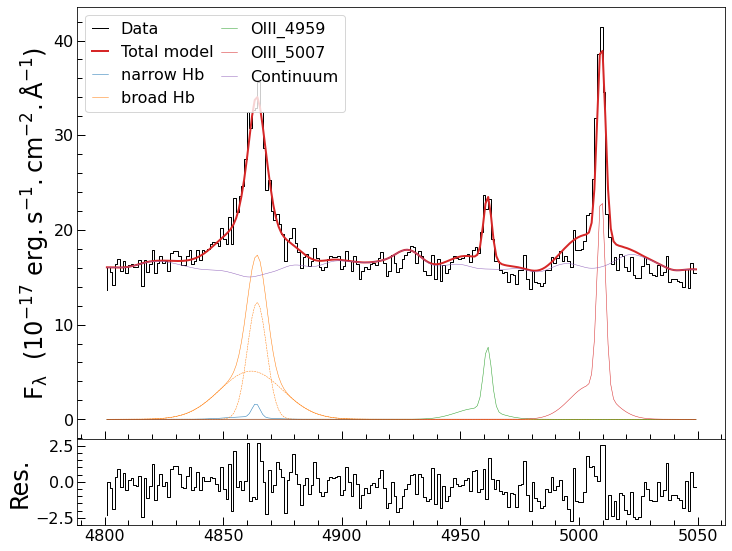

amplitude_0 = 1.6529, error: 2.7528
amp_c_1 = 12.3525, error: 1.6591
dv_c_1 = 182.2831, error: 35.7737
sigma_c_1 = 250.0889, error: 49.6079
amp_w0_1 = 0.4118, error: 0.1647
dv_w0_1 = -153.6365, error: 74.6953
sigma_w0_1 = 820.0155, error: 90.8228
amplitude_3 = 23.7830, error: 0.7054


In [11]:
def Fit_Hb(wave_use, flux_use, ferr, velc_tmpl, flux_tmpl, m_fit_cont):
    wave_dict = sagan.utils.line_wave_dict
    label_dict = sagan.utils.line_label_dict
    
    n_hb      = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                                    amplitude=3, dv=0,wavec=wave_dict['Hbeta'], name=f'narrow Hb', 
                                    fixed={'wavec': True, 'dv': True})
    OIII_5007 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                                    amplitude=3, dv=0, wavec=wave_dict['OIII_5007'], name=f'OIII_5007', 
                                    fixed={'wavec': True, 'dv': True})
    OIII_4959 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                                    amplitude=3, dv=0, wavec=wave_dict['OIII_4959'], name=f'OIII_4959', 
                                    fixed={'wavec': True, 'dv': True})
    b_hb      = sagan.Line_MultiGauss(n_components=2, amp_c=1, dv_c=280, sigma_c=100,
                                      amp_w0=0.3, dv_w0=0, sigma_w0=800,
                                      wavec=wave_dict['Hbeta'],
                                      name=f'broad Hb', fixed={'wavec': True},
                                      bounds={'amp_w0':(0,1),
                                              'sigma_c':(30, 300), 
                                              'dv_c':(-1000, 1000), 
                                              'sigma_w0':(500, 2000), 
                                              'dv_w0':(-1000,1000)}
                                     )    
    def tie_o3(model):
        return model['OIII_5007'].amplitude / 2.98
    OIII_4959.amplitude.tied = tie_o3
    
    def m_fit_cont_func(x):
        return m_fit_cont(x)
    cont = sagan.TierContinuum(y_func=m_fit_cont_func, amplitude=1.0, name=f'Continuum', x_static=wave_use)
    cont.amplitude.fixed = True
    
    m_init = n_hb+ b_hb + OIII_4959 + OIII_5007 + cont
                                            
    samples, m_fit_Hb = Fit_mcmc(wave_use, flux_use, ferr, m_init, nwalkers=40, nsteps=3000)
    #fig = corner.corner(samples, labels=param_names, quantiles=[0.16,0.5,0.84],\
    #                    smooth=False, show_titles=True, title_kwargs={"fontsize":12}, title_fmt='.3f')
    #plt.show()
    
    weights = 1/ferr**2
    ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Hb, weight=weights)
    ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
    plt.show()
    
    param_names = get_free_params(m_fit_Hb)
    best_fit_params     = np.median(samples, axis=0)
    best_fit_params_err = np.std(samples, axis=0)
    for i, param_name in enumerate(param_names):
        print(f"{param_name} = {best_fit_params[i]:.4f}, error: {best_fit_params_err[i]:.4f}")
                                      
    return m_fit_Hb, samples


ins = ((wave_use>4800)&(wave_use<5050))
m_fit_Hb, samples_Hb = Fit_Hb(wave_use[ins], flux_use[ins], ferr[ins], velc_OIII_tmpl, flux_OIII_tmpl, m_fit_cont)
